In [1]:
import os
# For Colab/Google Drive integration:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/FinRL/final')  # Change to your project folder in Drive

ValueError: mount failed

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set up plotting style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

In [ ]:


class ColabDataAggregator:
    """
    Colab-friendly data aggregator for converting per-second data to different timeframes.
    """

    def __init__(self):
        """Initialize the aggregator with default settings."""
        self.supported_timeframes = ['1min', '5min', '10min', '15min', '30min', '1H']
        self.aggregation_stats = {}

    def aggregate_to_timeframe_data(self, df: pd.DataFrame, timeframe: str = '1min') -> pd.DataFrame:
        """
        Aggregate per-second data to specified timeframe data.

        Args:
            df: Input DataFrame with per-second data
            timeframe: Timeframe for aggregation ('1min', '5min', '10min', etc.)

        Returns:
            Aggregated DataFrame
        """
        print(f"Aggregating data to {timeframe} timeframe...")
        print(f"Original data shape: {df.shape}")
        print(f"Original columns: {len(df.columns)}")

        # Convert system_time to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(df['system_time']):
            df['system_time'] = pd.to_datetime(df['system_time'])

        # Create timeframe-level timestamp based on specified timeframe
        if timeframe == '1min':
            df['timeframe_time'] = df['system_time'].dt.floor('min')
            time_label = 'minute'
        elif timeframe == '5min':
            df['timeframe_time'] = df['system_time'].dt.floor('5min')
            time_label = '5-minute'
        elif timeframe == '10min':
            df['timeframe_time'] = df['system_time'].dt.floor('10min')
            time_label = '10-minute'
        elif timeframe == '15min':
            df['timeframe_time'] = df['system_time'].dt.floor('15min')
            time_label = '15-minute'
        elif timeframe == '30min':
            df['timeframe_time'] = df['system_time'].dt.floor('30min')
            time_label = '30-minute'
        elif timeframe == '1H':
            df['timeframe_time'] = df['system_time'].dt.floor('H')
            time_label = 'hourly'
        else:
            raise ValueError(f"Unsupported timeframe: {timeframe}. Supported: {', '.join(self.supported_timeframes)}")

        # Define aggregation strategies for different column types
        aggregation_rules = self._get_aggregation_rules(df)

        print(f"Aggregation rules defined for {len(aggregation_rules)} columns")

        # Perform aggregation
        print(f"Performing {time_label}-level aggregation...")
        aggregated_df = df.groupby('timeframe_time').agg(aggregation_rules).reset_index()

        # Rename the timeframe_time column back to system_time
        aggregated_df = aggregated_df.rename(columns={'timeframe_time': 'system_time'})

        # Drop the original index column if it exists
        if 'Unnamed: 0' in aggregated_df.columns:
            aggregated_df = aggregated_df.drop('Unnamed: 0', axis=1)

        print(f"Aggregated data shape: {aggregated_df.shape}")

        # Store statistics
        self.aggregation_stats[timeframe] = {
            'original_records': len(df),
            'aggregated_records': len(aggregated_df),
            'compression_ratio': len(df) / len(aggregated_df),
            'timeframe': timeframe,
            'time_range_start': aggregated_df['system_time'].min(),
            'time_range_end': aggregated_df['system_time'].max()
        }

        return aggregated_df

    def _get_aggregation_rules(self, df: pd.DataFrame) -> Dict:
        """Define aggregation rules for different column types."""
        aggregation_rules = {}

        # Basic market data - use mean for prices, sum for volumes
        price_columns = ['midpoint', 'spread']
        volume_columns = ['buys', 'sells']

        # Use mean for price-related columns
        for col in price_columns:
            if col in df.columns:
                aggregation_rules[col] = 'mean'

        # Use sum for volume-related columns
        for col in volume_columns:
            if col in df.columns:
                aggregation_rules[col] = 'sum'

        # Handle bid/ask distance columns (use mean)
        for i in range(15):  # 0-14 levels
            for side in ['bids', 'asks']:
                col = f'{side}_distance_{i}'
                if col in df.columns:
                    aggregation_rules[col] = 'mean'

        # Handle bid/ask notional columns (use sum)
        for i in range(15):  # 0-14 levels
            for side in ['bids', 'asks']:
                for notional_type in ['notional', 'cancel_notional', 'limit_notional', 'market_notional']:
                    col = f'{side}_{notional_type}_{i}'
                    if col in df.columns:
                        aggregation_rules[col] = 'sum'

        # Handle sentiment and risk scores (use mean)
        if 'sentiment_score' in df.columns:
            aggregation_rules['sentiment_score'] = 'mean'
        if 'risk_score' in df.columns:
            aggregation_rules['risk_score'] = 'mean'

        # Use first value for system_time (representative timestamp for the timeframe)
        aggregation_rules['system_time'] = 'first'

        return aggregation_rules

    def load_data(self, file_path: str) -> pd.DataFrame:
        """Load data from CSV file."""
        print(f"Loading data from {file_path}...")
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df

    def save_data(self, df: pd.DataFrame, file_path: str) -> None:
        """Save aggregated data to CSV file."""
        df.to_csv(file_path, index=False)
        print(f"✓ Aggregated data saved to: {file_path}")

    def print_statistics(self, timeframe: str = None) -> None:
        """Print aggregation statistics."""
        if timeframe is None:
            timeframe = list(self.aggregation_stats.keys())[-1] if self.aggregation_stats else None

        if timeframe and timeframe in self.aggregation_stats:
            stats = self.aggregation_stats[timeframe]
            print(f"\nAggregation Statistics for {timeframe}:")
            print(f"  Original records: {stats['original_records']:,}")
            print(f"  Aggregated records: {stats['aggregated_records']:,}")
            print(f"  Compression ratio: {stats['compression_ratio']:.2f}x")
            print(f"  Time range: {stats['time_range_start']} to {stats['time_range_end']}")

    def plot_aggregation_comparison(self, original_df: pd.DataFrame, aggregated_df: pd.DataFrame,
                                   timeframe: str, sample_size: int = 1000) -> None:
        """Plot comparison between original and aggregated data."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Data Aggregation Comparison: {timeframe}', fontsize=16)

        # Sample data for plotting (to avoid memory issues)
        if len(original_df) > sample_size:
            original_sample = original_df.sample(n=sample_size, random_state=42).sort_values('system_time')
        else:
            original_sample = original_df.sort_values('system_time')

        # Plot 1: Price comparison
        axes[0, 0].plot(original_sample['system_time'], original_sample['midpoint'],
                        alpha=0.6, label='Original (1s)', linewidth=0.5)
        axes[0, 0].plot(aggregated_df['system_time'], aggregated_df['midpoint'],
                        label=f'Aggregated ({timeframe})', linewidth=2)
        axes[0, 0].set_title('Midpoint Price Comparison')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].legend()
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Plot 2: Volume comparison
        axes[0, 1].plot(original_sample['system_time'], original_sample['buys'],
                        alpha=0.6, label='Original (1s)', linewidth=0.5)
        axes[0, 1].plot(aggregated_df['system_time'], aggregated_df['buys'],
                        label=f'Aggregated ({timeframe})', linewidth=2)
        axes[0, 1].set_title('Buy Volume Comparison')
        axes[0, 1].set_ylabel('Volume')
        axes[0, 1].legend()
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Plot 3: Spread comparison
        axes[1, 0].plot(original_sample['system_time'], original_sample['spread'],
                        alpha=0.6, label='Original (1s)', linewidth=0.5)
        axes[1, 0].plot(aggregated_df['system_time'], aggregated_df['spread'],
                        label=f'Aggregated ({timeframe})', linewidth=2)
        axes[1, 0].set_title('Spread Comparison')
        axes[1, 0].set_ylabel('Spread')
        axes[1, 0].legend()
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Plot 4: Sentiment comparison (if available)
        if 'sentiment_score' in original_df.columns and 'sentiment_score' in aggregated_df.columns:
            axes[1, 1].plot(original_sample['system_time'], original_sample['sentiment_score'],
                            alpha=0.6, label='Original (1s)', linewidth=0.5)
            axes[1, 1].plot(aggregated_df['system_time'], aggregated_df['sentiment_score'],
                            label=f'Aggregated ({timeframe})', linewidth=2)
            axes[1, 1].set_title('Sentiment Score Comparison')
            axes[1, 1].set_ylabel('Sentiment Score')
            axes[1, 1].legend()
            axes[1, 1].tick_params(axis='x', rotation=45)
        else:
            # If no sentiment, show volume distribution
            axes[1, 1].hist(original_sample['buys'], alpha=0.6, bins=30, label='Original (1s)')
            axes[1, 1].hist(aggregated_df['buys'], alpha=0.6, bins=30, label=f'Aggregated ({timeframe})')
            axes[1, 1].set_title('Volume Distribution Comparison')
            axes[1, 1].set_xlabel('Volume')
            axes[1, 1].set_ylabel('Frequency')
            axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

    def plot_compression_analysis(self) -> None:
        """Plot compression analysis for different timeframes."""
        if not self.aggregation_stats:
            print("No aggregation statistics available. Run aggregation first.")
            return

        timeframes = list(self.aggregation_stats.keys())
        compression_ratios = [self.aggregation_stats[tf]['compression_ratio'] for tf in timeframes]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Compression ratios
        bars = ax1.bar(timeframes, compression_ratios, color='skyblue', alpha=0.7)
        ax1.set_title('Compression Ratios by Timeframe')
        ax1.set_ylabel('Compression Ratio (Original/Aggregated)')
        ax1.set_xlabel('Timeframe')

        # Add value labels on bars
        for bar, ratio in zip(bars, compression_ratios):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{ratio:.1f}x', ha='center', va='bottom')

        # Plot 2: Record counts
        original_counts = [self.aggregation_stats[tf]['original_records'] for tf in timeframes]
        aggregated_counts = [self.aggregation_stats[tf]['aggregated_records'] for tf in timeframes]

        x = np.arange(len(timeframes))
        width = 0.35

        ax2.bar(x - width/2, original_counts, width, label='Original Records', alpha=0.7)
        ax2.bar(x + width/2, aggregated_counts, width, label='Aggregated Records', alpha=0.7)

        ax2.set_title('Record Counts by Timeframe')
        ax2.set_ylabel('Number of Records')
        ax2.set_xlabel('Timeframe')
        ax2.set_xticks(x)
        ax2.set_xticklabels(timeframes)
        ax2.legend()

        plt.tight_layout()
        plt.show()

    def run_aggregation_pipeline(self, input_file: str, timeframe: str = '1min',
                                output_file: str = None, plot_comparison: bool = True) -> pd.DataFrame:
        """
        Run the complete aggregation pipeline.

        Args:
            input_file: Path to input CSV file
            timeframe: Timeframe for aggregation
            output_file: Path to save output (optional)
            plot_comparison: Whether to plot comparison charts

        Returns:
            Aggregated DataFrame
        """
        print("=" * 60)
        print(f"Colab Data Aggregator - {timeframe} Aggregation")
        print("=" * 60)

        # Load data
        original_df = self.load_data(input_file)

        # Perform aggregation
        aggregated_df = self.aggregate_to_timeframe_data(original_df, timeframe)

        # Print statistics
        self.print_statistics(timeframe)

        # Save data if output file specified
        if output_file:
            self.save_data(aggregated_df, output_file)

        # Plot comparison if requested
        if plot_comparison:
            self.plot_aggregation_comparison(original_df, aggregated_df, timeframe)
            self.plot_compression_analysis()

        print("\n" + "=" * 60)
        print("Aggregation pipeline completed successfully!")
        print("=" * 60)

        return aggregated_df

In [ ]:
def example_usage():
    """Example usage of the ColabDataAggregator."""

    # Initialize aggregator
    aggregator = ColabDataAggregator()

    # Example: Run 5-minute aggregation
    aggregated_df = aggregator.run_aggregation_pipeline(
        input_file=f'data/BTC_1sec_with_sentiment_risk_train.csv',
        timeframe=timeframe,
        output_file=f'data/BTC_{timeframe}_with_sentiment_risk_train.csv',
        plot_comparison=True
    )

    print("ColabDataAggregator initialized successfully!")
    print("Use the following methods:")
    print("- run_aggregation_pipeline(): Complete pipeline")
    print("- aggregate_to_timeframe_data(): Just aggregation")
    print("- plot_aggregation_comparison(): Plot comparisons")
    print("- plot_compression_analysis(): Plot compression stats")

Colab Data Aggregator - 1min Aggregation
Loading data from data/BTC_1sec_with_sentiment_risk_train.csv...
Data loaded successfully. Shape: (494749, 158)
Aggregating data to 1min timeframe...
Original data shape: (494749, 158)
Original columns: 158
Aggregation rules defined for 157 columns
Performing minute-level aggregation...
Aggregated data shape: (8249, 158)

Aggregation Statistics for 1min:
  Original records: 494,749
  Aggregated records: 8,249
  Compression ratio: 59.98x
  Time range: system_time          2021-04-07 11:32:00+00:00
system_time   2021-04-07 11:32:42.122161+00:00
dtype: datetime64[ns, UTC] to system_time          2021-04-13 05:00:00+00:00
system_time   2021-04-13 05:00:00.123831+00:00
dtype: datetime64[ns, UTC]
✓ Aggregated data saved to: data/BTC_1min_with_sentiment_risk_train.csv


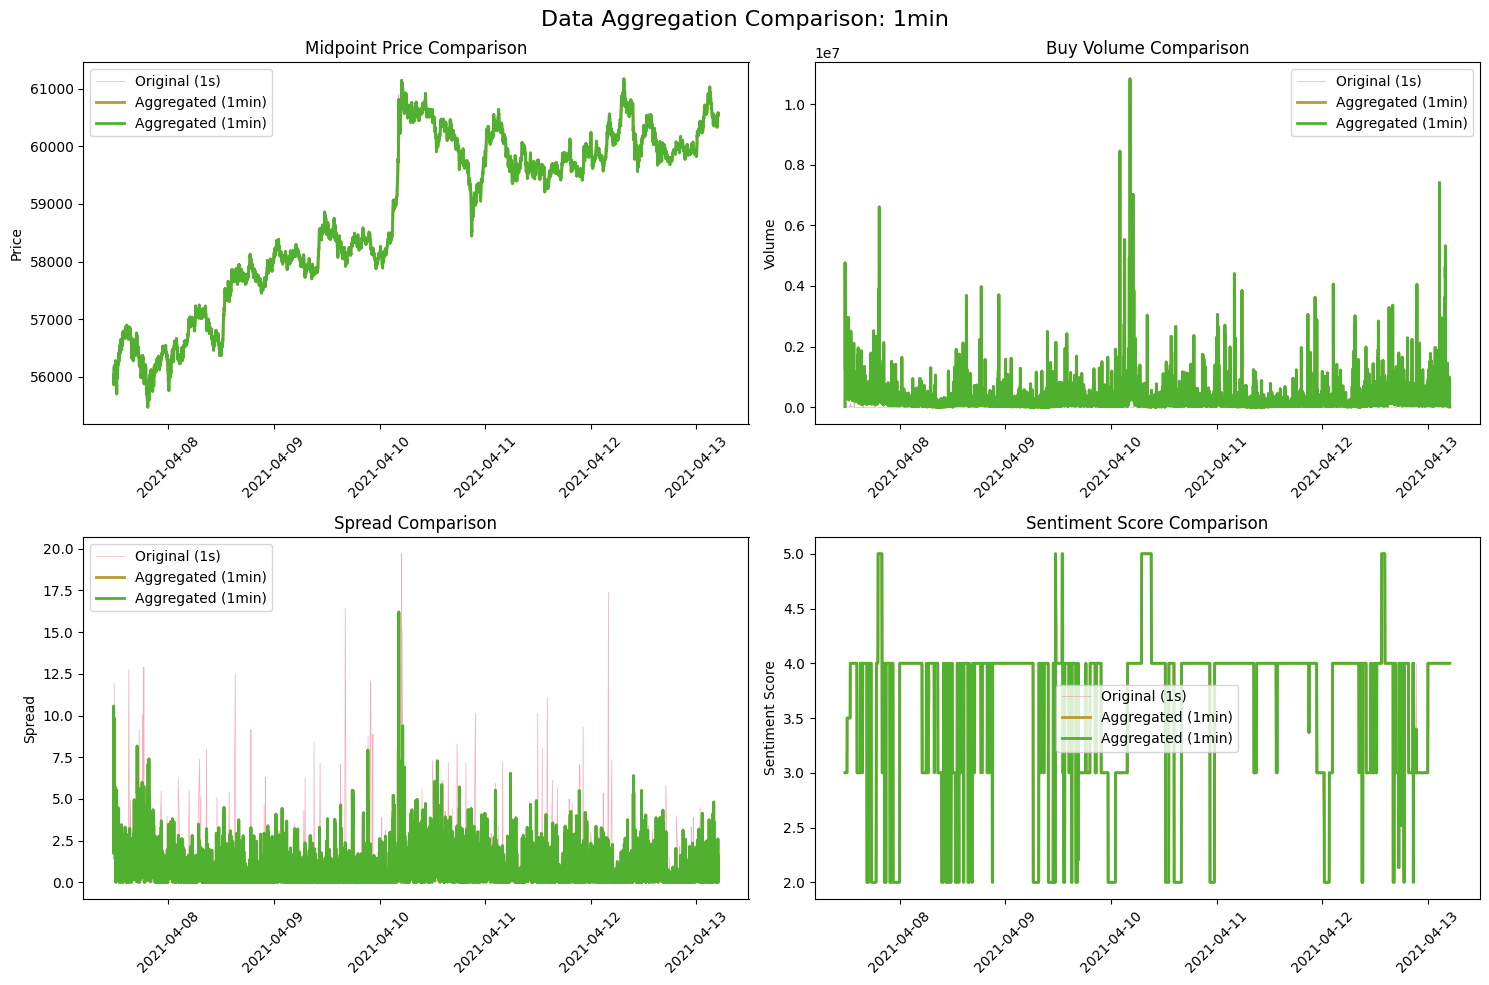

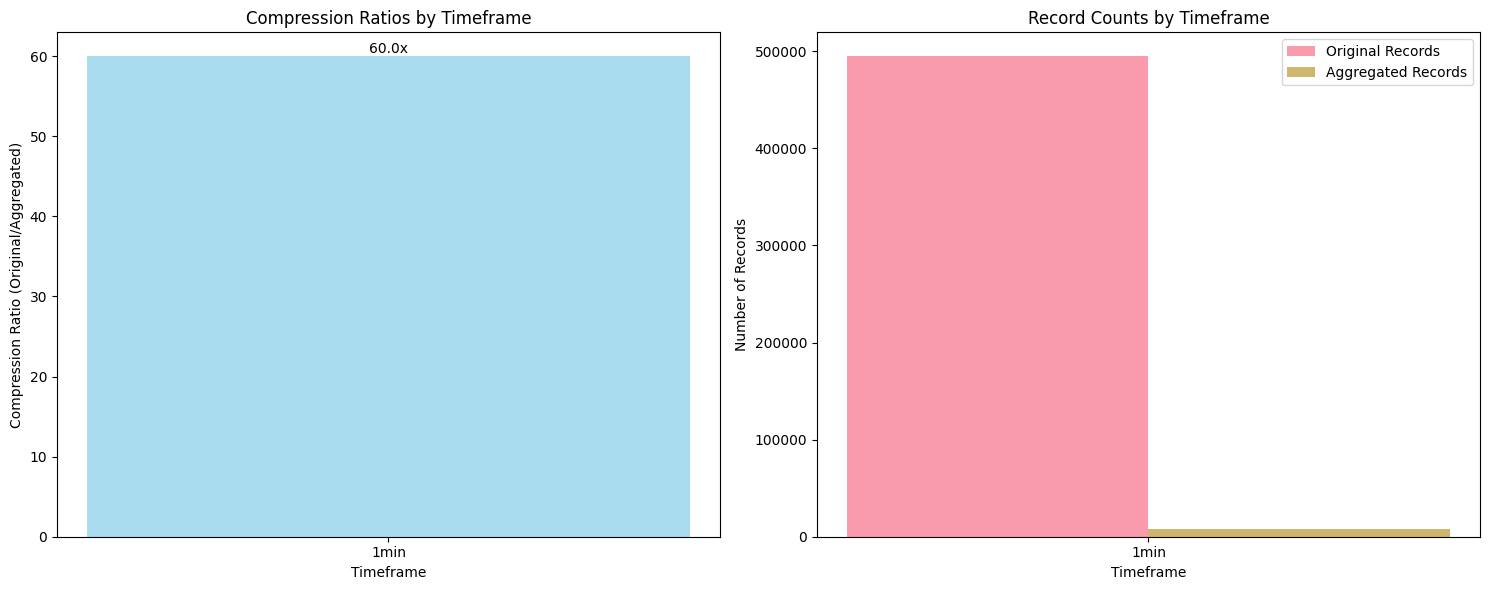


Aggregation pipeline completed successfully!
ColabDataAggregator initialized successfully!
Use the following methods:
- run_aggregation_pipeline(): Complete pipeline
- aggregate_to_timeframe_data(): Just aggregation
- plot_aggregation_comparison(): Plot comparisons
- plot_compression_analysis(): Plot compression stats


In [ ]:
timeframe = '1min'
example_usage()

Colab Data Aggregator - 5min Aggregation
Loading data from data/BTC_1sec_with_sentiment_risk_train.csv...
Data loaded successfully. Shape: (494749, 158)
Aggregating data to 5min timeframe...
Original data shape: (494749, 158)
Original columns: 158
Aggregation rules defined for 157 columns
Performing 5-minute-level aggregation...
Aggregated data shape: (1651, 158)

Aggregation Statistics for 5min:
  Original records: 494,749
  Aggregated records: 1,651
  Compression ratio: 299.67x
  Time range: system_time          2021-04-07 11:30:00+00:00
system_time   2021-04-07 11:32:42.122161+00:00
dtype: datetime64[ns, UTC] to system_time          2021-04-13 05:00:00+00:00
system_time   2021-04-13 05:00:00.123831+00:00
dtype: datetime64[ns, UTC]
✓ Aggregated data saved to: data/BTC_5min_with_sentiment_risk_train.csv


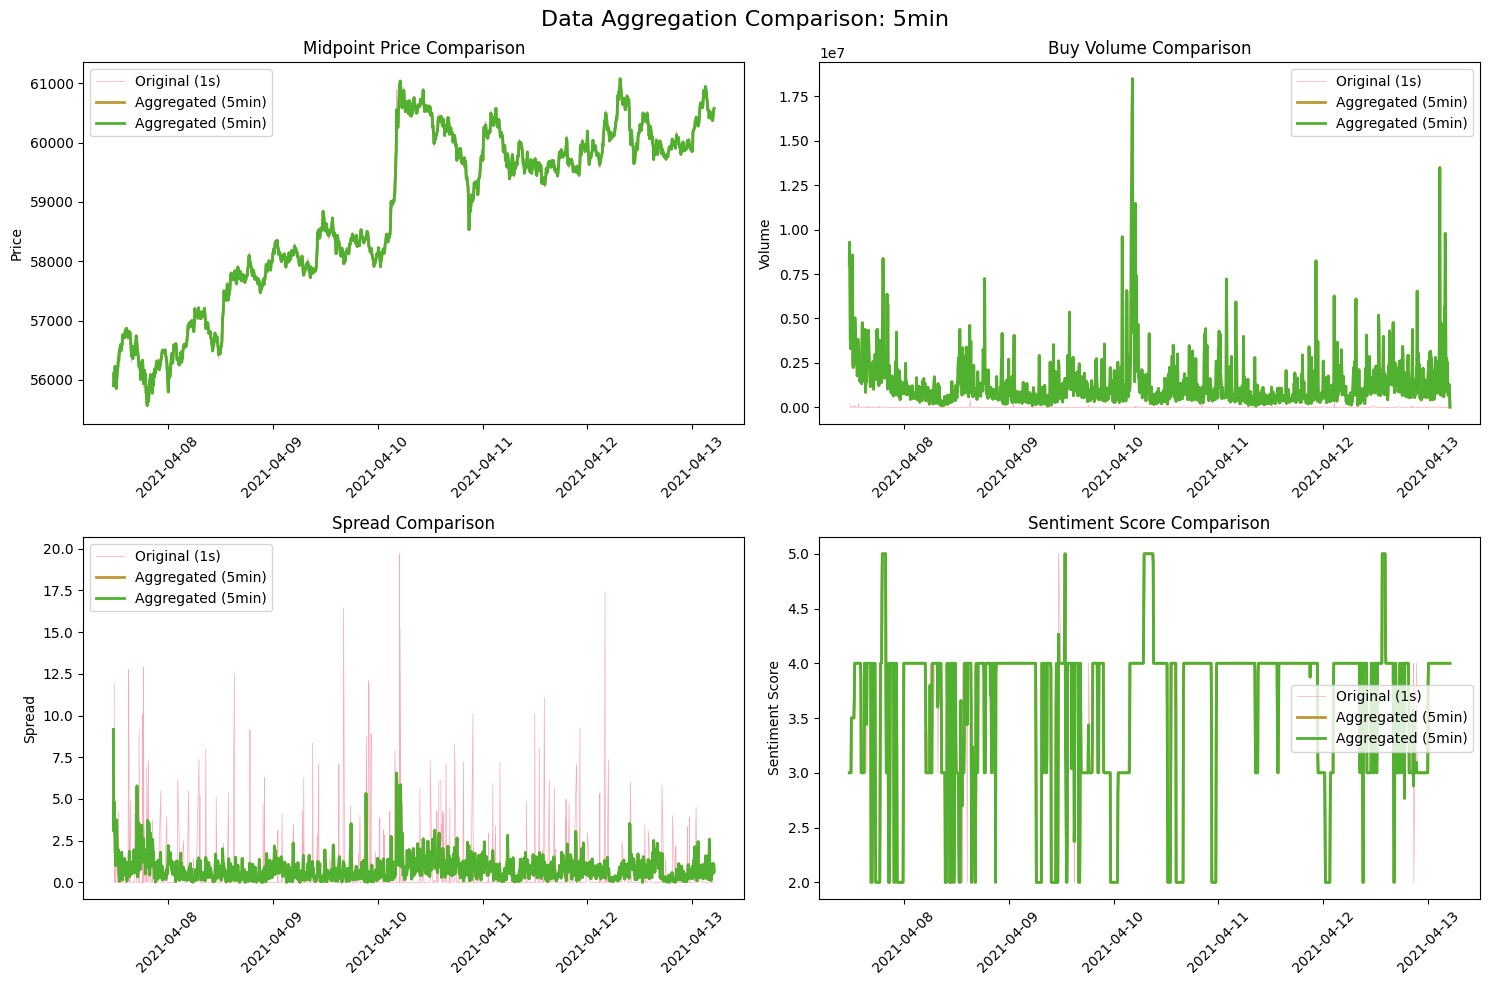

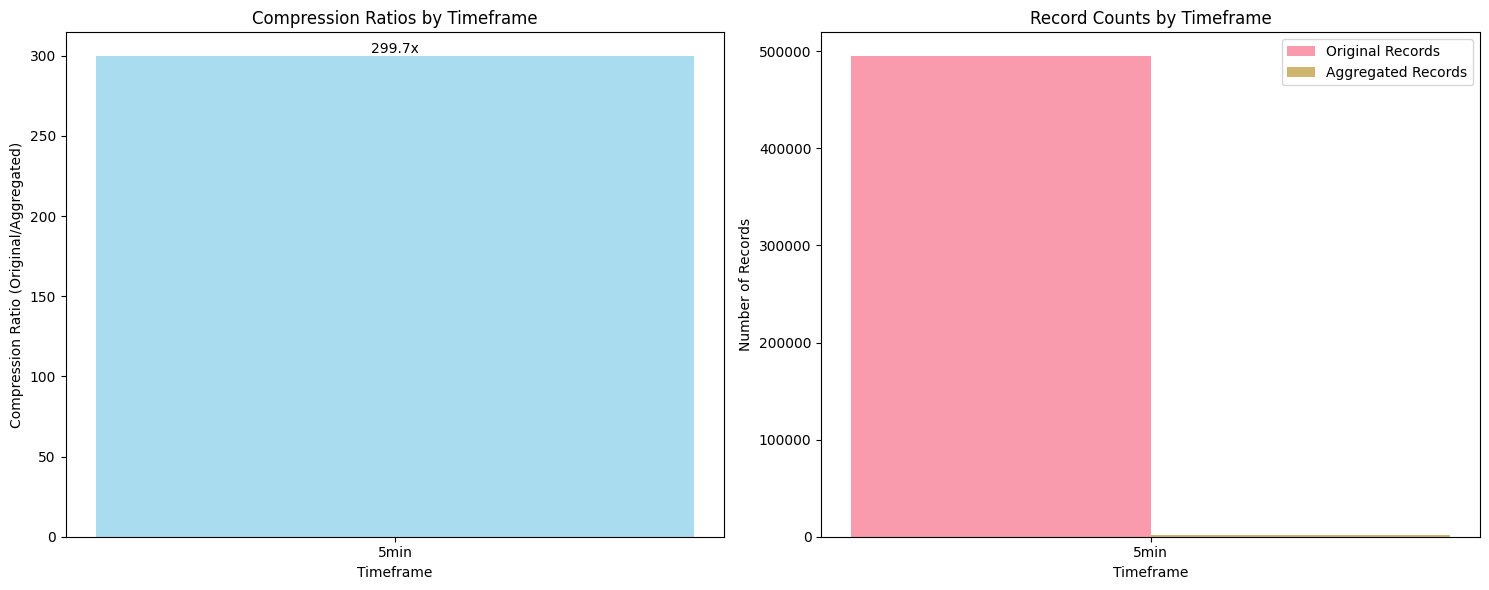


Aggregation pipeline completed successfully!
ColabDataAggregator initialized successfully!
Use the following methods:
- run_aggregation_pipeline(): Complete pipeline
- aggregate_to_timeframe_data(): Just aggregation
- plot_aggregation_comparison(): Plot comparisons
- plot_compression_analysis(): Plot compression stats


In [ ]:
timeframe = '5min'
example_usage()